In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import scipy.stats as stats
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(0, '../../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic
from roc_ps import get_shuffled_df, get_roc#all_func

#### Variables

In [8]:
top_path = 'C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/ps_res/res_UMAP_without_srin/'

file_name = top_path + 'ps_res_16052023.xlsx'
nn_file_name = top_path + 'nn_res_30052023.xlsx'

sheet_abun = 'abundance'
sheet_meta = 'meta'
sheet_umap = 'umap'
sheet_pcoa = 'pcoa'

#### Load data

In [9]:
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
nn_meta = pd.read_excel(nn_file_name, sheet_name = sheet_meta, index_col = 0)
print(meta.shape)
print(nn_meta.shape)

(7842, 31)
(514, 35)


In [10]:
both_meta = pd.concat([meta, nn_meta])
temp_meta = both_meta[both_meta['db'] == "temp_pyro"]
# temp_meta = both_meta[both_meta['db'].str.contains("temp")]

In [47]:
predict_group_size = 4

In [48]:
print(len(temp_meta[temp_meta['BV_bin'] == 1]))
print(len(temp_meta[(temp_meta['BV_bin'] == 1) & (temp_meta['time'] > predict_group_size)]))

31
20


#### Order

##### BV

In [41]:
def flatten_lst(lst):
    return [item for items in lst for item in items]

def select_df_by_indices(df, idx_lsts, bv_next, predict_group_size = 5):
    groups_names = [[i] * (predict_group_size - 1) for i, x in enumerate(idx_lsts)]
    flatten_idx_lst = flatten_lst(idx_lsts)
    flatten_names_lst = flatten_lst(groups_names)
    
    new_df = df.iloc[flatten_idx_lst]
    new_df['group_name'] = flatten_names_lst
    new_df['bv_next'] = bv_next
    
    return new_df

In [49]:
temp_meta_no = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, True]).reset_index()
bv_samples_idx = temp_meta_no[(temp_meta_no['BV_bin'] == 1) & (temp_meta_no['time'] > predict_group_size)].index
before_bv_lists = [list(range(num - (predict_group_size - 1), num)) for num in bv_samples_idx]
before_bv_df = select_df_by_indices(temp_meta_no, before_bv_lists, 1, predict_group_size)

###### Healthy

In [43]:
idx = (temp_meta_no['BV_bin'].rolling(window = predict_group_size).min() == 0).to_numpy()

In [44]:
healthy_bin_idx = (temp_meta_no.groupby('subjectID')['BV_bin'].rolling(window = predict_group_size).mean() == 0).to_numpy()
healthy_idx = temp_meta_no.iloc[healthy_bin_idx].index
filt_healthy_idx = [x for x in healthy_idx if x not in flatten_lst(before_bv_lists)]
before_healthy_lists = [list(range(num - (predict_group_size - 1), num)) for num in filt_healthy_idx]
before_healthy_df = select_df_by_indices(temp_meta_no, before_healthy_lists, 0, predict_group_size)

#### Aggregate 

In [54]:
def get_agg(df):
    agg_df = df.groupby('group_name')['mt_pseudotime'].aggregate(['min', 'max', 'mean', 'std', 'median'])
    agg_df['diff'] = agg_df['max'] - agg_df['min']
    agg_df['bv_next'] = df.bv_next.unique()[0]
    return agg_df

In [55]:
agg_bv = get_agg(before_bv_df)
agg_healthy = get_agg(before_healthy_df)
agg_df = pd.concat([agg_bv, agg_healthy])

In [45]:
print(len(bv_samples_idx))
print(len(healthy_idx))
print((len(bv_samples_idx) / len(healthy_idx)) * 100)

20
1459
1.3708019191226868


#### Plot trends

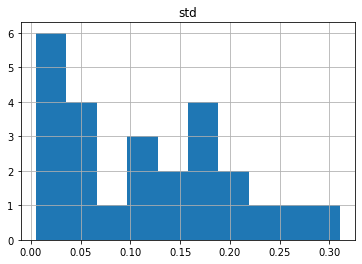

In [69]:
agg_df = temp_meta.groupby('subjectID')['mt_pseudotime'].aggregate(['std'])
agg_df.hist(column = 'std')
high_std_subjects = agg_df[agg_df['std'] > 0.05].index
filt_before_bv_df = before_bv_df[before_bv_df['subjectID'].isin(high_std_subjects)]

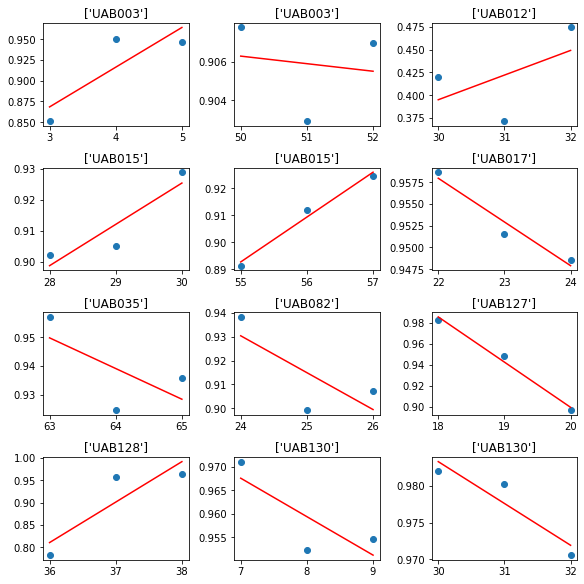

In [70]:
subjects_num = len(filt_before_bv_df.group_name.unique())
nrow = 4
ncol = subjects_num // nrow
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8), constrained_layout=True)
for group, ax in zip(filt_before_bv_df.group_name.unique(), axes.flat):
    plot_df = filt_before_bv_df[before_bv_df['group_name'] == group]
    subject = plot_df.subjectID.unique()
    x = plot_df['time']
    y = plot_df['mt_pseudotime']
    ax.set_title(subject)
    ax.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

In [24]:
before_bv_df
len(before_bv_df.subjectID.unique())

16

#### roc

In [352]:
def all_func(df, n, pred_col, label_col):
    filt_df = df[df[label_col].notna()]
    pred_arr = filt_df[pred_col]

    shuffled_df = get_shuffled_df(filt_df, n, label_col)
    final_df = get_roc(shuffled_df, pred_arr)

    return final_df, shuffled_df

In [353]:
pred_df_bv, shuff = all_func(agg_df, 99, 'median', 'bv_next')
pred_df_bv.iloc[0, 2]

0.6850250626566416

In [323]:
dict_roc = {'bv': pred_df_bv}
roc_path = top_path + str(predict_group_size - 1) + 'days_without_bv_diff_05062023.xlsx'
paga_res.save_excel(roc_path, dict_roc)
print(str(predict_group_size - 1))

#### t-test

<AxesSubplot:title={'center':'median'}, xlabel='bv_next'>

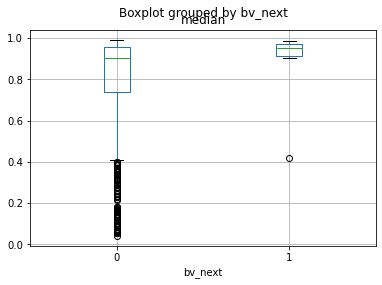

In [302]:
agg_df.boxplot(by = 'bv_next', column = 'median')

<AxesSubplot:title={'center':'std'}, xlabel='bv_next'>

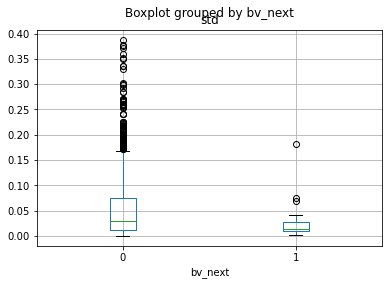

In [252]:
agg_df.boxplot(by = 'bv_next', column = 'std')